In [421]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import numpy as np
import seaborn as sns
import pandas
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing

In [422]:
#definições de funções
def clean_vector(vectors, target_length):
    cleaned_vectors = []
    seconds = vectors[0][0]
    sum_vector = [0,0,0]
    mean_vector = [0,0,0]
    counter = 0
    for vector in vectors:
        if vector[0] < 0:
            print(vector)
            continue
        if vector[0] != seconds:
            mean_vector = [sum_vector[0] / counter, sum_vector[1] / counter, sum_vector[2] / counter]
            cleaned_vectors.append([seconds, mean_vector[0],mean_vector[1],mean_vector[2]])
            counter = 0
            seconds = vector[0]
            sum_vector = [0,0,0]
        sum_vector = [sum_vector[0] + vector[1],sum_vector[1] + vector[2],sum_vector[2] + vector[3]]
        counter = counter + 1
    return cleaned_vectors

In [423]:
def magnitude_of_vectors(vectors):
    dot_product = []
    for vector in vectors:
        dot_product.append(np.linalg.norm(vector[1:]))
    return dot_product

In [424]:
def unify(vectors1, vectors2):
    unified = []
    for i in range(0, min(len(vectors1), len(vectors2))):
        unified.append((vectors1[i]+vectors2[i])/2)
    return unified

In [425]:
def remove_outlier(df, key, threshold):
    df = df[(np.abs((df[key] - df[key].mean())/df[key].std(ddof=0)) < threshold)]
    df.index = range(0, len(df.time))
    return df

In [426]:
def plot_graph_v(vectordf, titulo):
    plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    fig, ax1 = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(18)
    ax1.plot(vectordf.time, vectordf.x, label='x')
    ax1.plot(vectordf.time, vectordf.y, label='y')
    ax1.plot(vectordf.time, vectordf.z, label='z')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Frequencia (s)', color='tab:red')
    ax2.plot(df_buxco.time[0:], df_buxco.frequency[0:], label='frequencia', color='tab:red')
    ax1.set_title(titulo)
    ax1.set_xlabel('Tempo (s)')
    ax1.legend(loc=2)
    ax2.legend(loc=1)
    fig.savefig(titulo + '.png')

In [427]:
def plot_graph_m(vectordf, titulo):
    fig, ax1 = plt.subplots()
    plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    fig.set_figheight(6)
    fig.set_figwidth(18)
    ax1.plot(vectordf.time, vectordf.magnitude, label='magnitude')
    ax1.set_title(titulo)
    ax1.set_xlabel('Tempo (s)')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Frequencia', color='tab:orange')
    ax2.plot(df_buxco.time[0:], df_buxco.frequency[0:], label='frequency', color='tab:orange')
    ax1.legend(loc=2)
    ax2.legend(loc=1)
    fig.savefig(titulo + '.png')

In [428]:
def normalize(df, columns):
    for column in columns:
        x = [df[column]]
        normalized = preprocessing.normalize(x)
        df[column] = normalized[0]
    return df

In [429]:
def read_signa_csv():
    df = pandas.read_csv('rato1-signa-test.csv')
    df['time'] = pandas.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S.%f")
    df['time'] = df['time'] - df['time'][0]
    df['time'] = df['time'].dt.total_seconds()
    return df


In [430]:
def read_buxco_csv():
    df_buxco = pandas.read_csv('buxco.csv')
    df_buxco['time'] = df_buxco.ti+df_buxco.te+((df_buxco.eip + 107.36)/1000)
    df_buxco['time'] = df_buxco.time.cumsum()
    return df_buxco

In [431]:
def get_sensors(df):
    temperature = []
    axes = []
    rest = []
    ax = []
    df.sort_values(by=['time'], inplace=True)
    for index, data in df.iterrows():
        if float(data['axes_x']) == 0 and float(data['axes_y']) == 0 and float(data['axes_z']) == 0 and float(data['temperature']) == 0:
            rest.append(data)
        elif float(data['axes_x']) == 0 and float(data['axes_y']) == 0 and float(data['axes_z']) == 0 and float(data['temperature']) != 0:
            temperature.append([data['time'], data['sensor_id'],data['temperature']])
        else:
            z = data['axes_z']
            if isinstance(data['axes_z'], str):
                z = data['axes_z'].replace(' ','')
            if np.isnan(float(z)):
                continue
            ax.append([data['time'], data['sensor_id'],data['axes_x'],data['axes_y'],data['axes_z']])
            axes.append([data['time'], data['sensor_id'],float(data['axes_x']),float(data['axes_y']),float(z)])
    axes = pandas.DataFrame(axes, columns=['time', 'sensor_id', 'x', 'y', 'z'])
    vectors_30 = []
    vectors_105 = []
    vectors_29 = []
    last_time = 0
    for index,row in axes.iterrows():
        if(row.time < 0 or row.time > 700):
            continue
        try:
            if(row.sensor_id == 29.0):
                vectors_29.append([row.time, row.x,row.y,float(row.z)])
            if(row.sensor_id == 30.0):
                vectors_30.append([row.time, row.x,row.y,float(row.z)])
            if(row.sensor_id == 105.0):
                vectors_105.append([row.time, row.x,row.y,float(row.z)])
        except:
            print(row)
        last_time = row.time
            
    return vectors_29, vectors_30, vectors_105

In [432]:
def get_magnitude(df):
    return magnitude_of_vectors(zip(df.x,df.y,df.z))

In [433]:
def unify_sensors(s_29, s_30, s_105):
    return unify(unify(s_29.magnitude, s_30.magnitude), s_105.magnitude)

In [434]:
def plot_buxco(df):
    fig, axs = plt.subplots(7, figsize=(15, 50))
    axs[0].plot(df.index.values[0:], df.frequency[0:])
    axs[1].plot(df.index.values[0:], df.penh[0:])
    axs[2].plot(df.index.values[0:], df.rt[0:])
    axs[3].plot(df.index.values[0:], df.mv[0:])
    axs[4].plot(df.index.values[0:], df.ti[0:])
    axs[5].plot(df.index.values[0:], df.te[0:])
    axs[6].plot(df.index.values[0:], df.eip[0:])
    axs[0].set_title("FREQUÊNCIA RESPIRATÓRIA")
    axs[0].set_xlabel("eventos")
    axs[1].set_title("PenH")
    axs[1].set_xlabel("eventos")
    axs[2].set_title("TEMPO DE RELAXAMENTO")
    axs[2].set_xlabel("eventos")
    axs[3].set_title("VOLUME MINUTO")
    axs[3].set_xlabel("eventos")
    plt.savefig('graficos.png')

In [435]:
def remove_sensor_outlier(df, threshold):
    df = remove_outlier(df, 'x', threshold)
    df = remove_outlier(df, 'y', threshold)
    df = remove_outlier(df, 'z', threshold)
    return df

In [436]:
def get_magnitude(df):
    df['magnitude'] = magnitude_of_vectors(zip(df.x, df.y,df.z))
    return df

In [437]:
def plot_points(df):
    fig = plt.figure(num=None, figsize=(18, 18), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(df.x, df.y, df.z, c='r', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


    plt.show()

In [438]:
####fim definições de funções

df = read_signa_csv()
df_buxco = read_buxco_csv()
vectors_29, vectors_30, vectors_105 = get_sensors(df)

In [439]:
#cl_vectors_30 = clean_vector(vectors_30, len(df_buxco))
#cl_vectors_105 = clean_vector(vectors_105, len(df_buxco))
#cl_vectors_29 = clean_vector(vectors_29, len(df_buxco))

In [440]:
sensor_29 = pandas.DataFrame(vectors_29, columns=['time', 'x', 'y', 'z'])
sensor_29['magnitude'] = get_magnitude(sensor_29)

sensor_30 = pandas.DataFrame(vectors_30, columns=['time', 'x', 'y', 'z'])
sensor_30['magnitude'] = get_magnitude(sensor_30)

sensor_105 = pandas.DataFrame(vectors_105, columns=['time', 'x', 'y', 'z'])
sensor_105['magnitude'] = get_magnitude(sensor_105)


mean_mag = pandas.DataFrame(zip(sensor_105.time,unify_sensors(sensor_29, sensor_30, sensor_105)), columns=['time', 'magnitude'])


mean_mag.to_csv('csvs/1-magnitude media.csv')
sensor_29.to_csv('csvs/1-sensor 29.csv')
sensor_30.to_csv('csvs/1-sensor 30.csv')
sensor_105.to_csv('csvs/1-sensor 105.csv')

sensor_29 = remove_sensor_outlier(sensor_29, 3)
sensor_30 = remove_sensor_outlier(sensor_30, 3)
sensor_105 = remove_sensor_outlier(sensor_105, 3)

sensor_29 = get_magnitude(sensor_29)
sensor_30 = get_magnitude(sensor_30)
sensor_105 = get_magnitude(sensor_105)

mean_mag = pandas.DataFrame(zip(sensor_105.time, unify_sensors(sensor_29, sensor_30, sensor_105)), columns=['time', 'magnitude'])

mean_mag.to_csv('csvs/2-magnitude media.csv')
sensor_29.to_csv('csvs/2-sensor 29.csv')
sensor_30.to_csv('csvs/2-sensor 30.csv')
sensor_105.to_csv('csvs/2-sensor 105.csv')

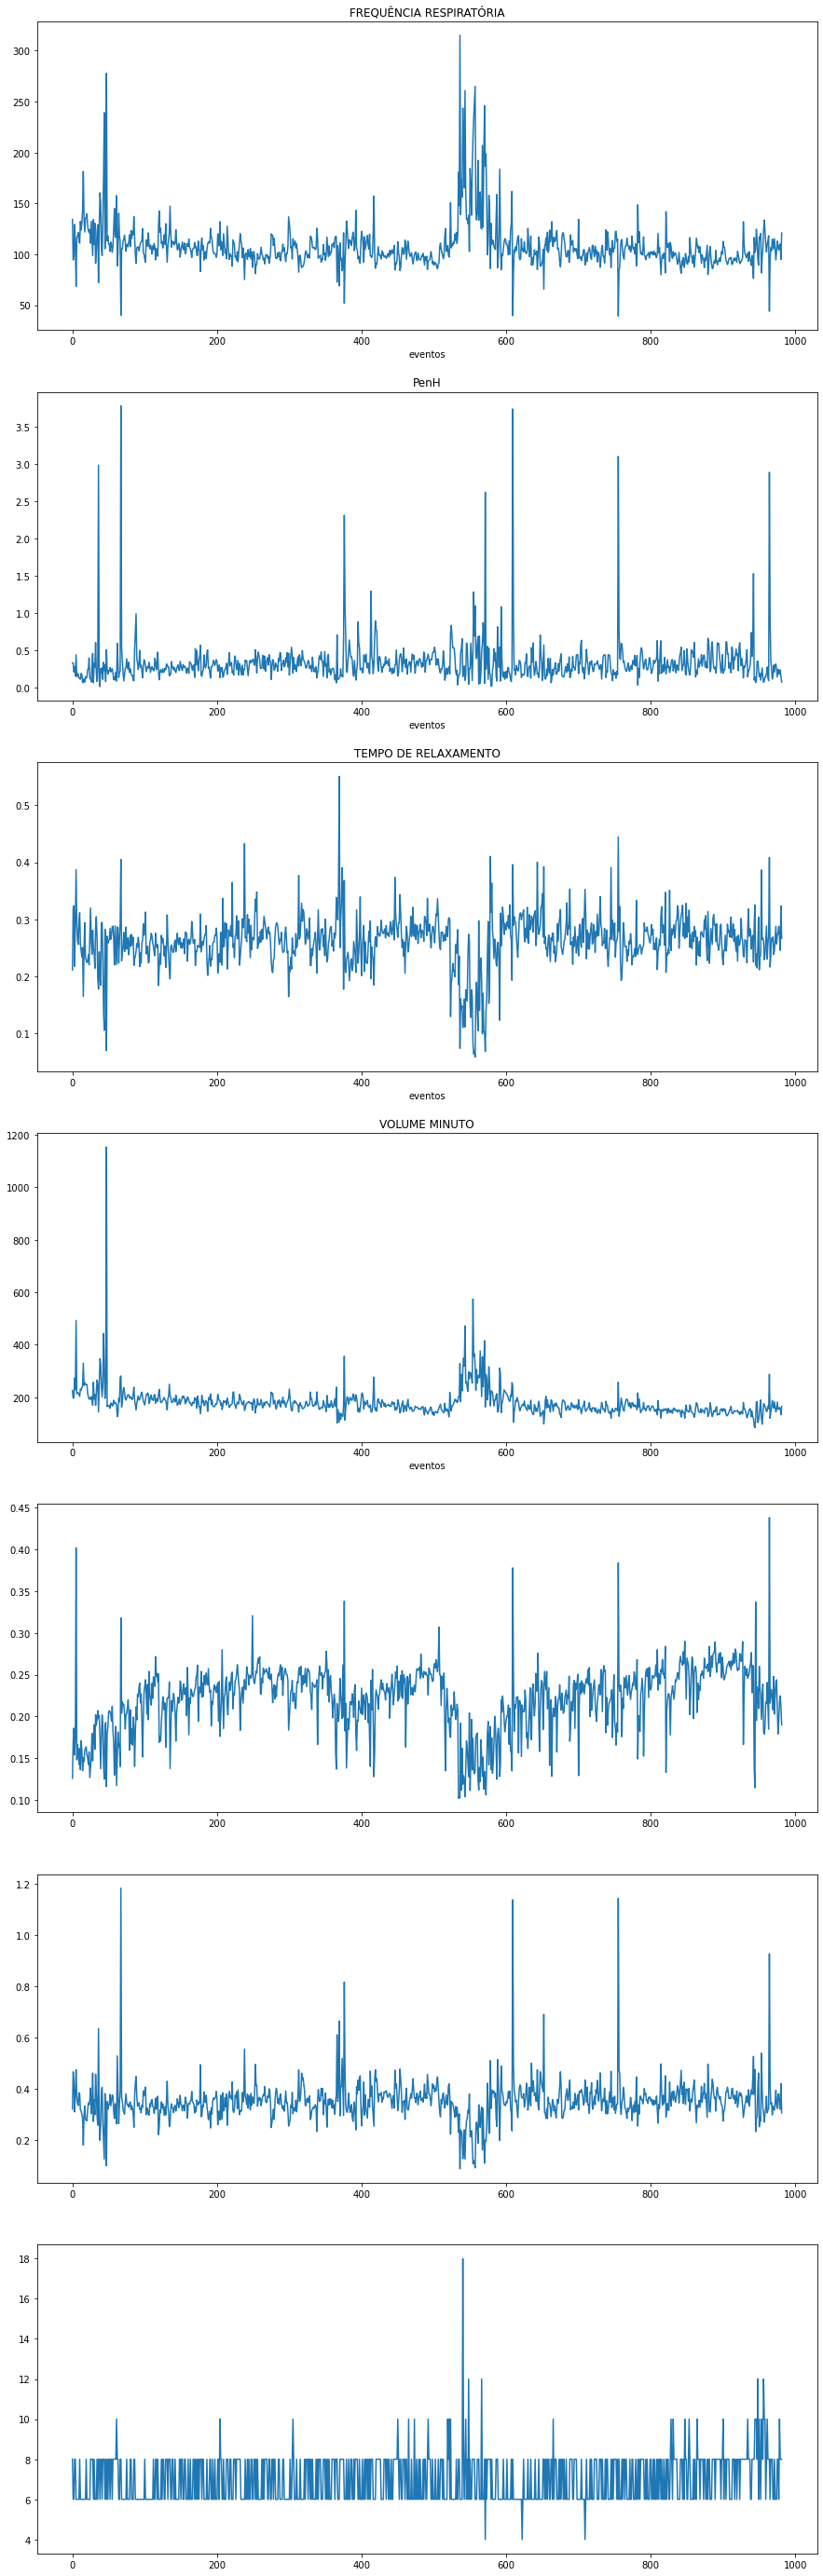

In [441]:
plot_buxco(df_buxco)

<Figure size 1440x480 with 0 Axes>

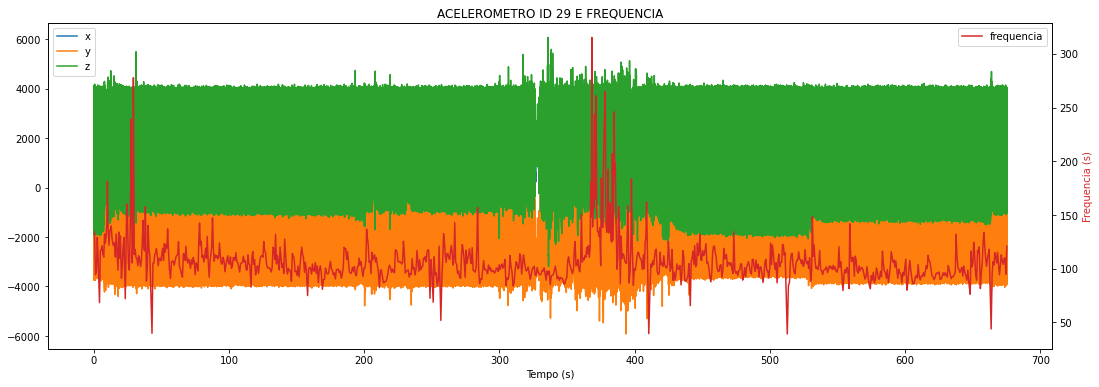

<Figure size 1440x480 with 0 Axes>

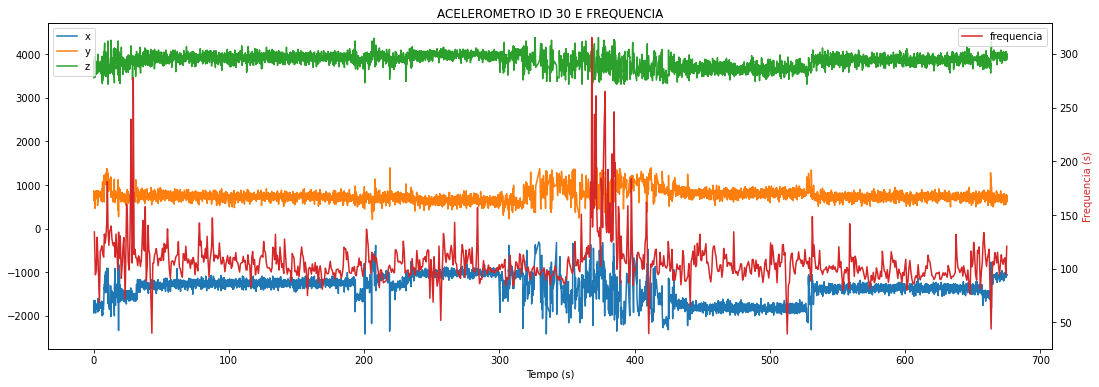

<Figure size 1440x480 with 0 Axes>

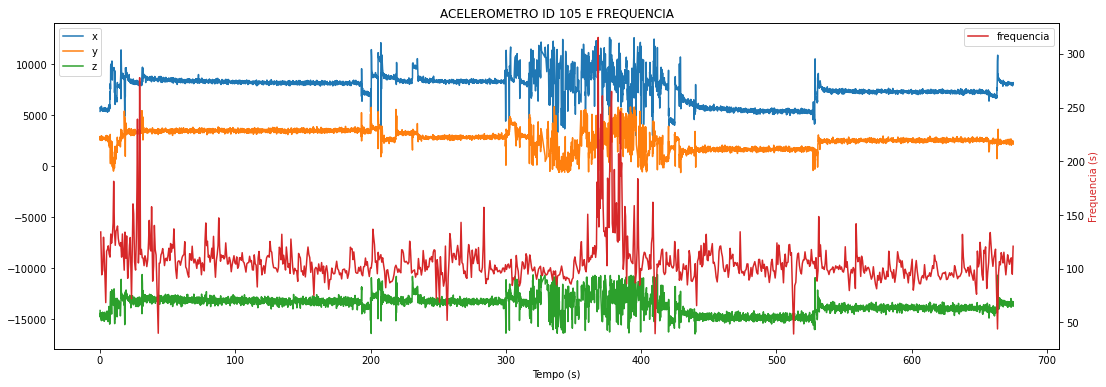

In [442]:
plot_graph_v(sensor_29, "ACELEROMETRO ID 29 E FREQUENCIA")
plot_graph_v(sensor_30, "ACELEROMETRO ID 30 E FREQUENCIA")
plot_graph_v(sensor_105, "ACELEROMETRO ID 105 E FREQUENCIA")

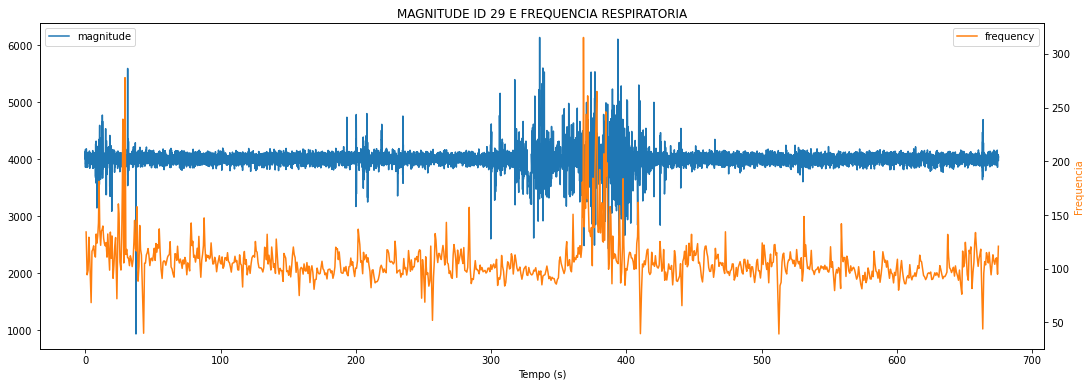

<Figure size 1440x480 with 0 Axes>

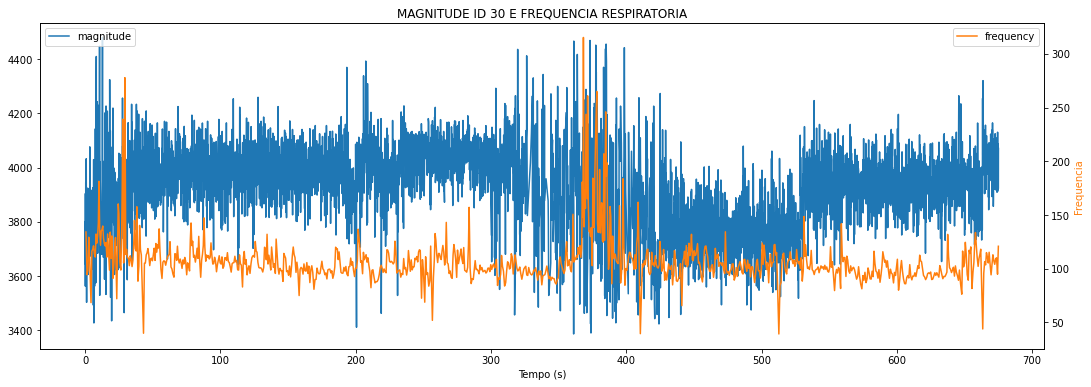

<Figure size 1440x480 with 0 Axes>

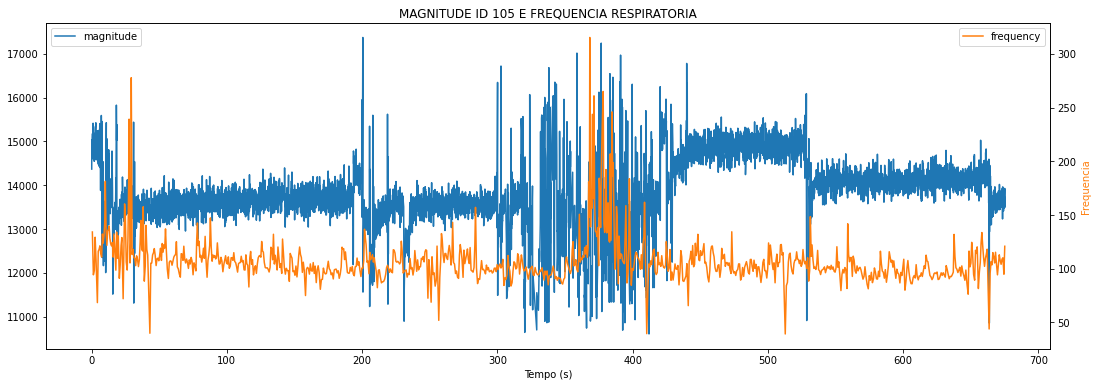

<Figure size 1440x480 with 0 Axes>

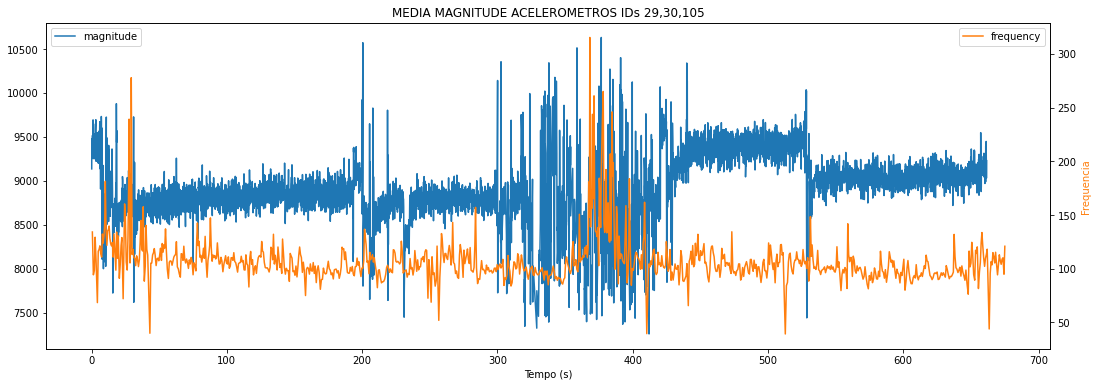

<Figure size 1440x480 with 0 Axes>

In [443]:
plot_graph_m(sensor_29, "MAGNITUDE ID 29 E FREQUENCIA RESPIRATORIA")
plot_graph_m(sensor_30, "MAGNITUDE ID 30 E FREQUENCIA RESPIRATORIA")
plot_graph_m(sensor_105, "MAGNITUDE ID 105 E FREQUENCIA RESPIRATORIA")
plot_graph_m(mean_mag, "MEDIA MAGNITUDE ACELEROMETROS IDs 29,30,105")

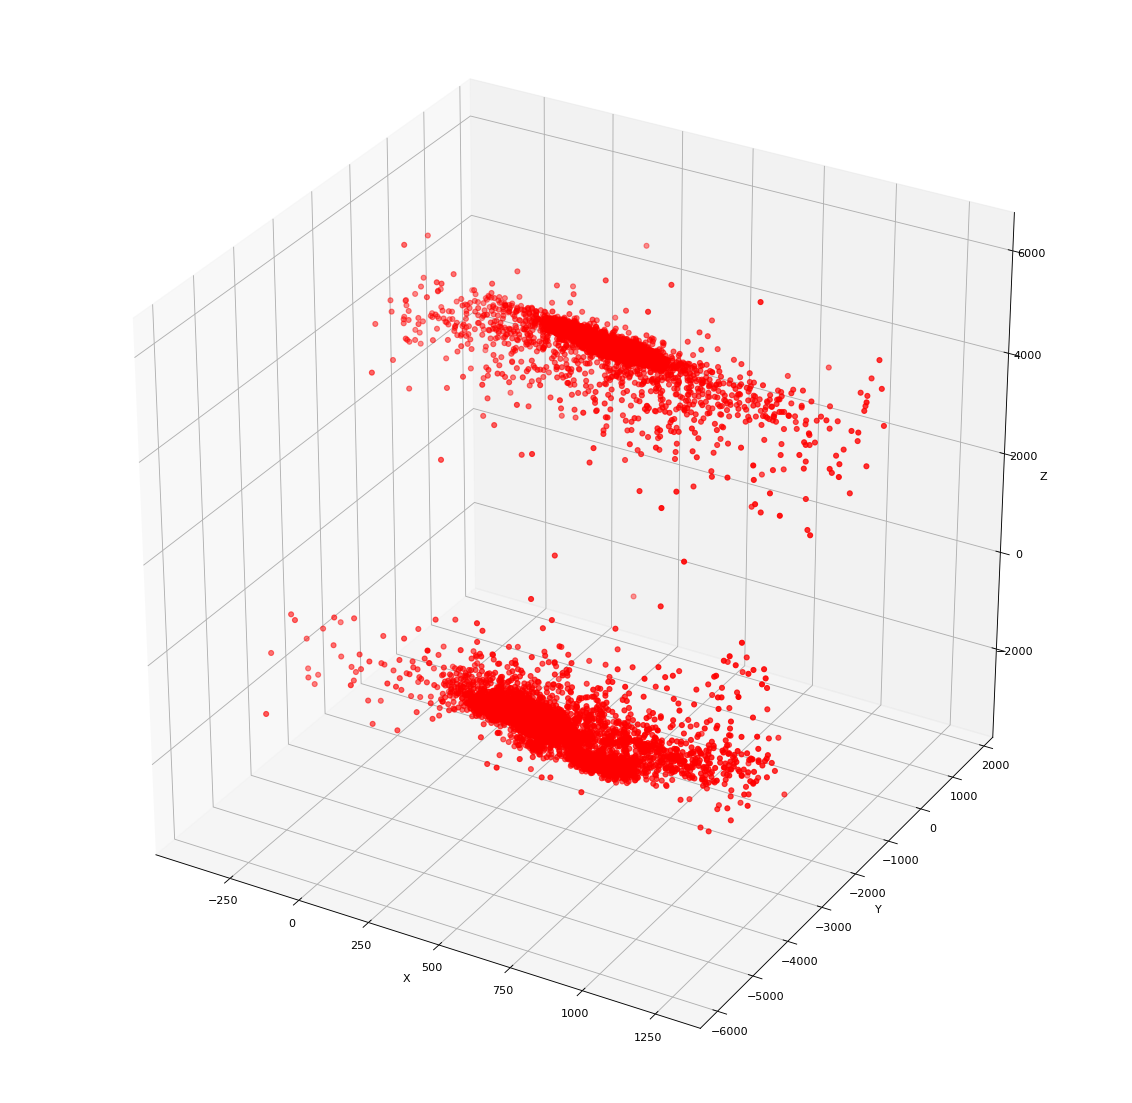

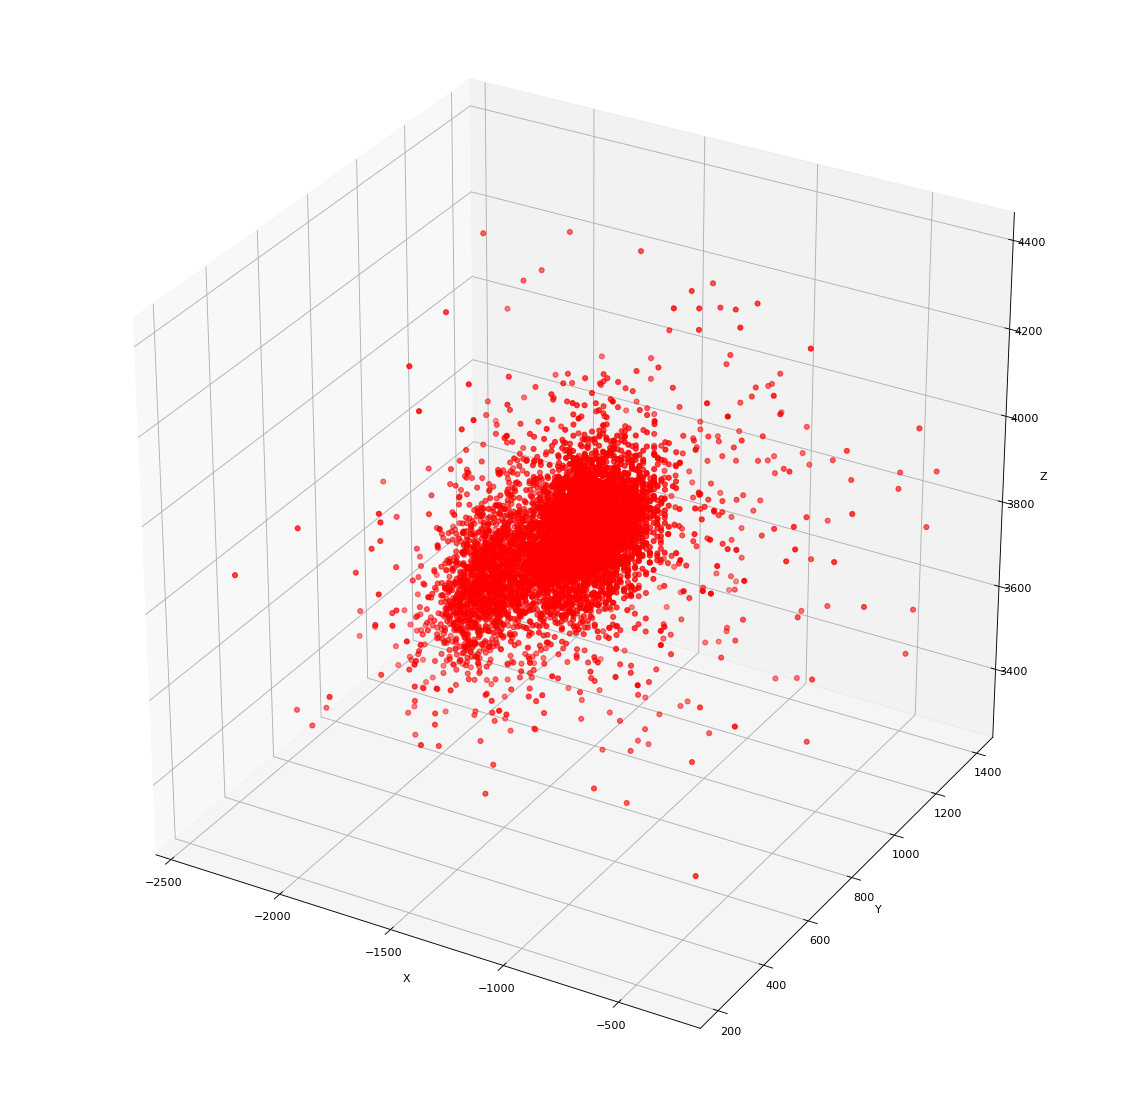

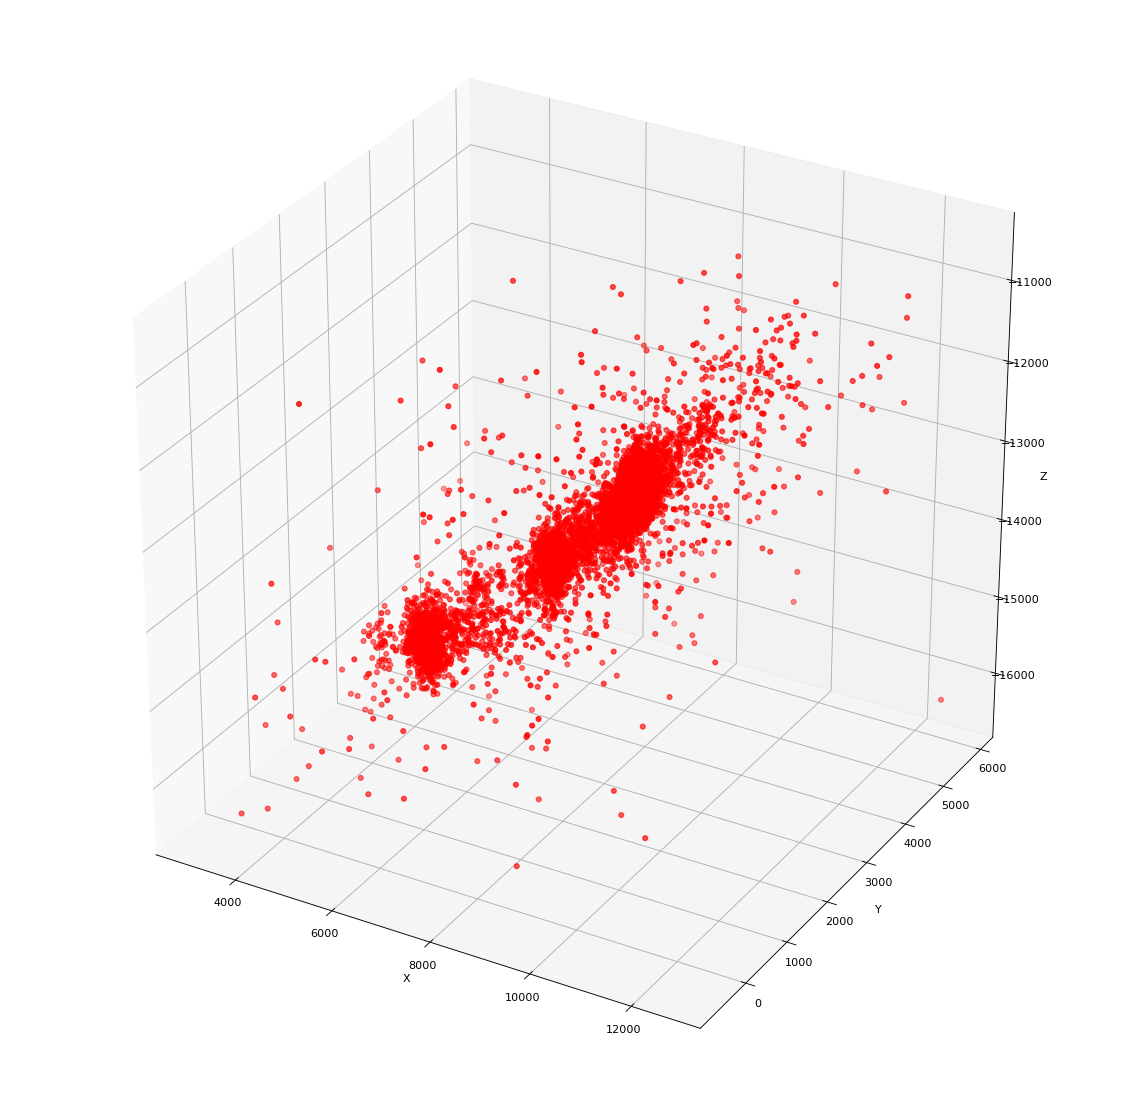

In [444]:
plot_points(sensor_29)
plot_points(sensor_30)
plot_points(sensor_105)


In [447]:
#Normalização dos dados
normalize(sensor_29, ['x', 'y', 'z', 'magnitude'])#muda o dataframe inplace
normalize(sensor_30, ['x', 'y', 'z', 'magnitude'])
normalize(sensor_105, ['x', 'y', 'z', 'magnitude'])
normalize(df_buxco, ['frequency'])

,frequency,penh,rt,mv,te,ti,eip,time
0,0.038755,0.331564,0.210798,225.829210,0.321070,0.126000,8,0.562430
1,0.027253,0.328262,0.318040,196.099875,0.465995,0.169742,6,1.311527
2,0.028491,0.210667,0.323635,200.527395,0.422123,0.186005,6,2.033015
3,0.037347,0.277827,0.217341,272.539841,0.309916,0.154000,8,2.612290
4,0.031270,0.157493,0.292707,228.587323,0.380000,0.174085,8,3.281735
...,...,...,...,...,...,...,...,...
977,0.030070,0.224645,0.287628,155.336661,0.380883,0.195308,6,672.380480
978,0.031469,0.178785,0.269585,161.238496,0.333465,0.217117,10,673.048421
979,0.031818,0.238015,0.245207,157.182799,0.320000,0.224535,8,673.708317
980,0.027410,0.143052,0.323423,133.429881,0.420104,0.212000,8,674.455780


In [448]:
def plot(sensor):
    fig, ax1 = plt.subplots()
    plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    fig.set_figheight(6)
    fig.set_figwidth(18)

    ax1.plot(sensor.time, sensor.magnitude, label='magnitude')
    ax1.plot(sensor.time, sensor.x, label='x')
    ax1.plot(sensor.time, sensor.y, label='y')
    ax1.plot(sensor.time, sensor.z, label='z')
    ax1.plot(df_buxco.time, df_buxco.frequency, label='frequencia')
    ax1.set_title("Acelerometro, magnitude e frequencia respiratoria")
    ax1.set_xlabel('Tempo (s)')
    ax1.legend(loc=2)

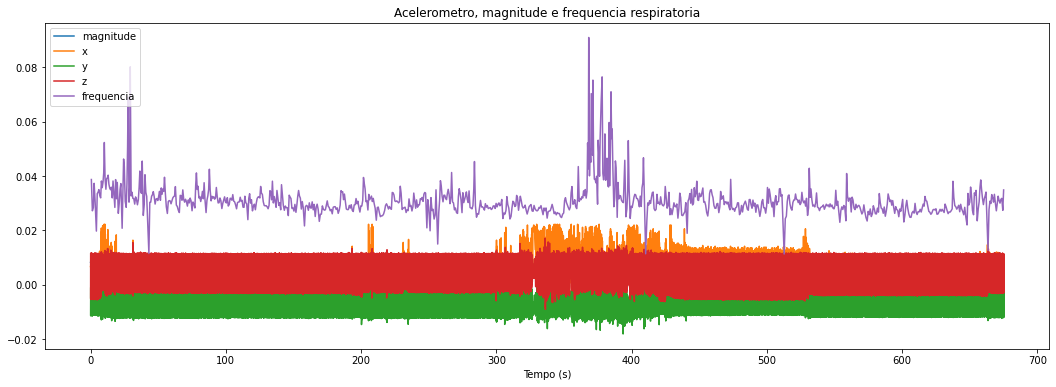

<Figure size 1440x480 with 0 Axes>

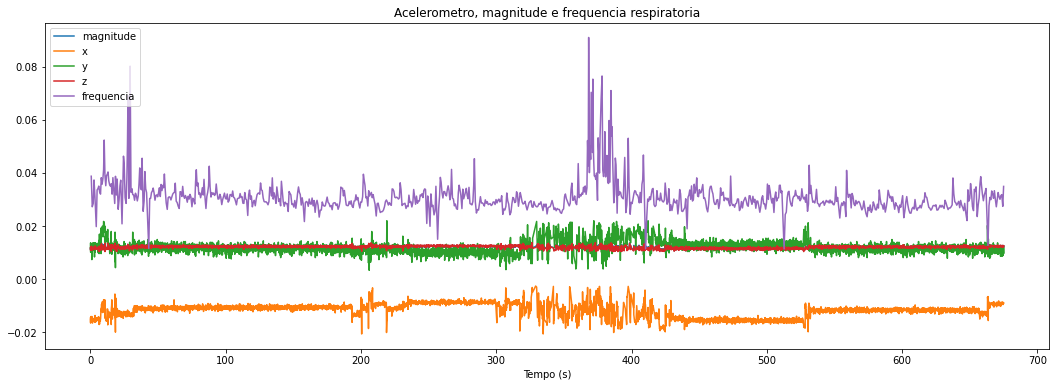

<Figure size 1440x480 with 0 Axes>

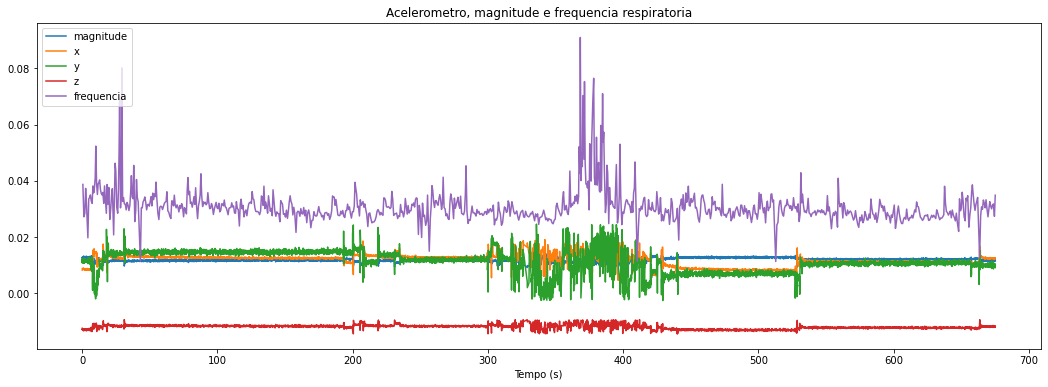

<Figure size 1440x480 with 0 Axes>

In [449]:
#plot dos dados normaizados
plot(sensor_29)
plot(sensor_30)
plot(sensor_105)

In [462]:
def approximate_data(df, target):
    mag = df
    fake_dex = 0
    mag_sum = 0
    mag_quantity = 0
    result = []
    for index, data in mag.iterrows():
        if data[0] > target.time[fake_dex]:
            result.append(mag_sum/mag_quantity)
            fake_dex += 1
            mag_sum = 0
            mag_quantity = 0
            if(fake_dex >= len(target.time)):
                break
        mag_sum += data.magnitude
        mag_quantity += 1
    return result

In [524]:
#reduzindo o tamanho do dataset
processed_sensor_29 = approximate_data(sensor_29, df_buxco)
processed_sensor_30 = approximate_data(sensor_30, df_buxco)
processed_sensor_105 = approximate_data(sensor_105, df_buxco)

In [527]:
def plot_processed_data(data):
    plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(df_buxco.time, data, label='x')
    plt.plot(df_buxco.time, df_buxco.frequency, label='s')

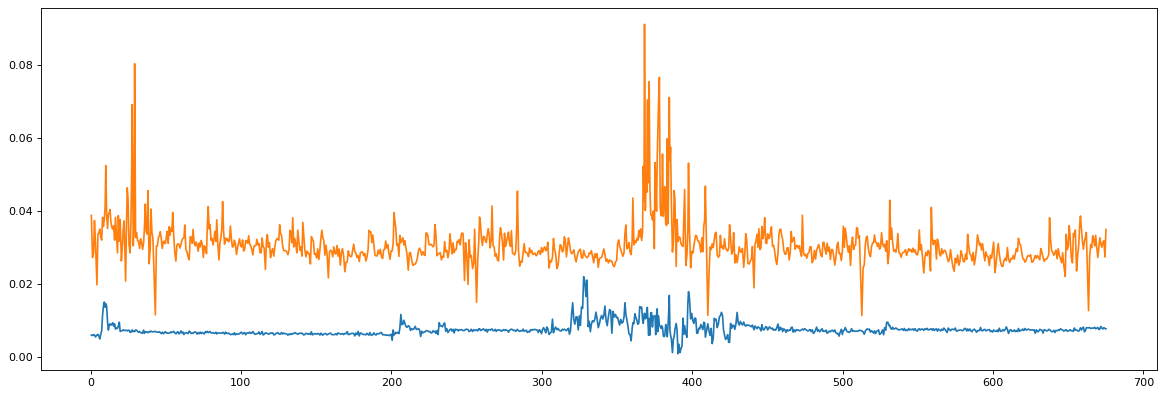

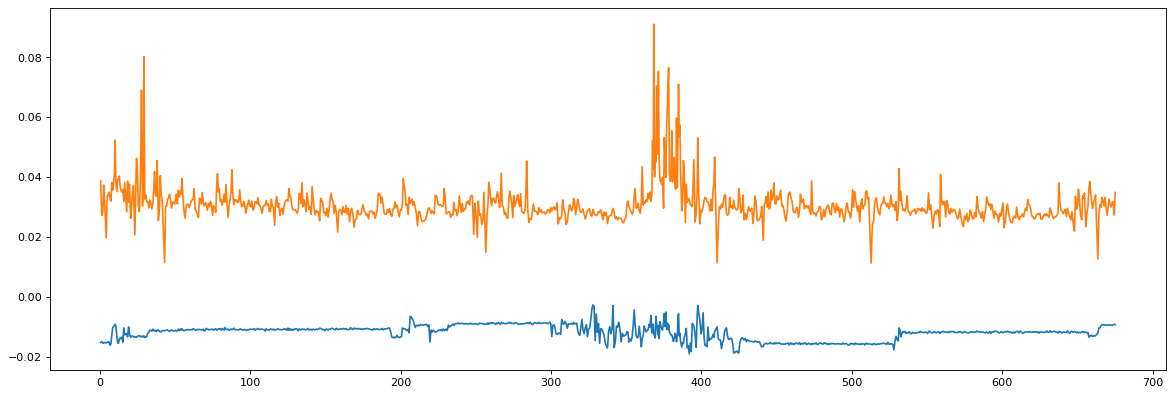

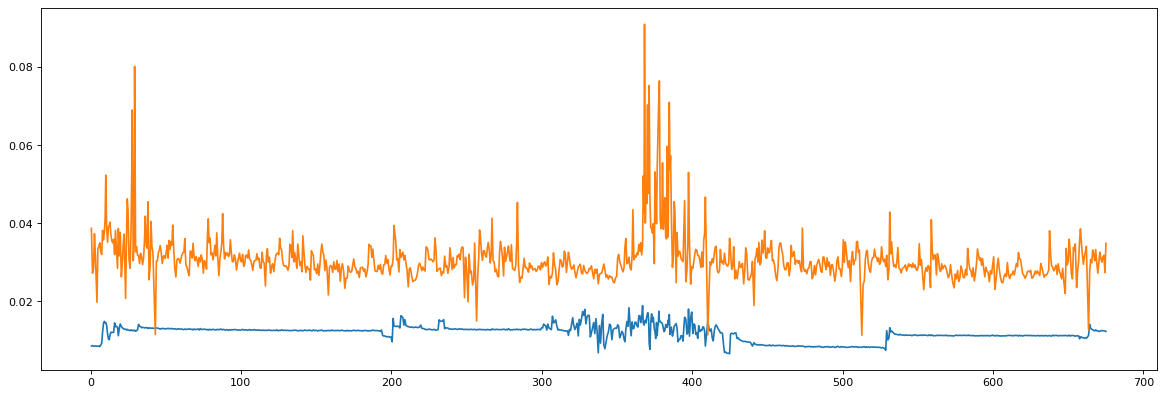

In [528]:
plot_processed_data(processed_sensor_29)
plot_processed_data(processed_sensor_30)
plot_processed_data(processed_sensor_105)

In [535]:
def plot_scatter(data1, data2):
    plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(data1, data2,c='r', marker='o')

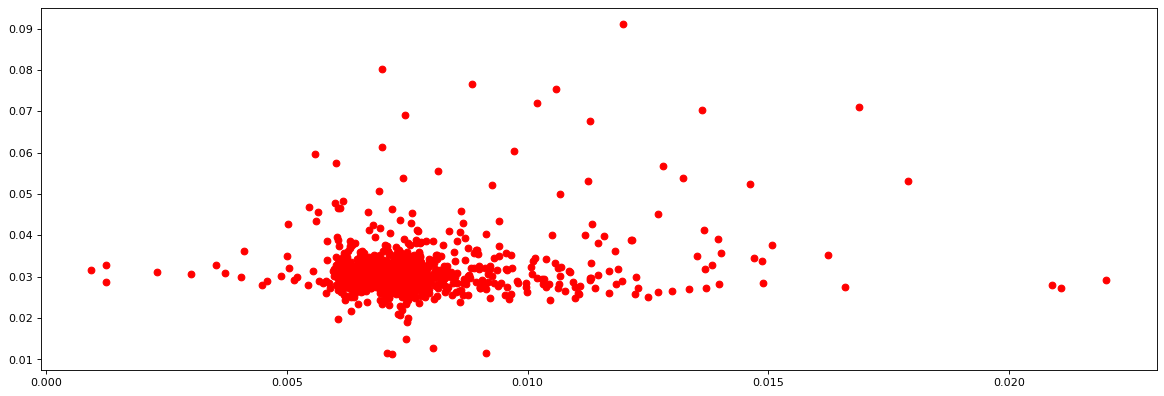

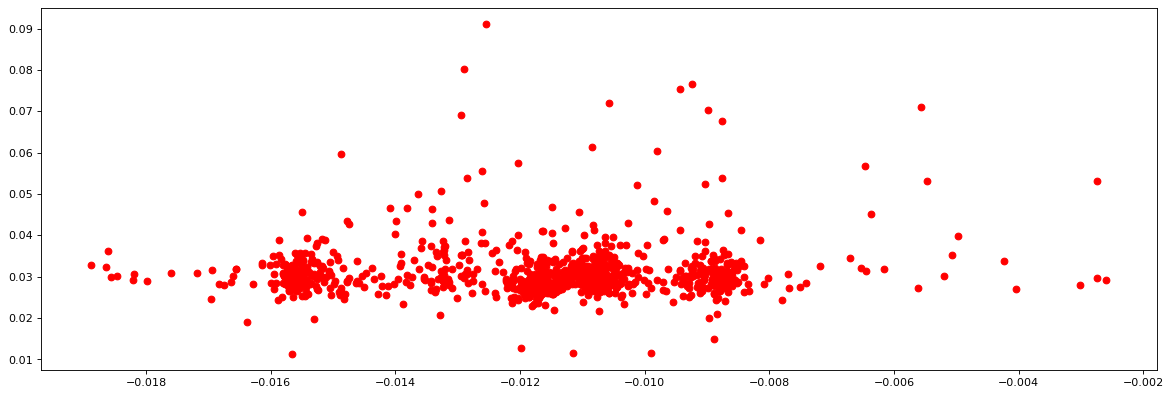

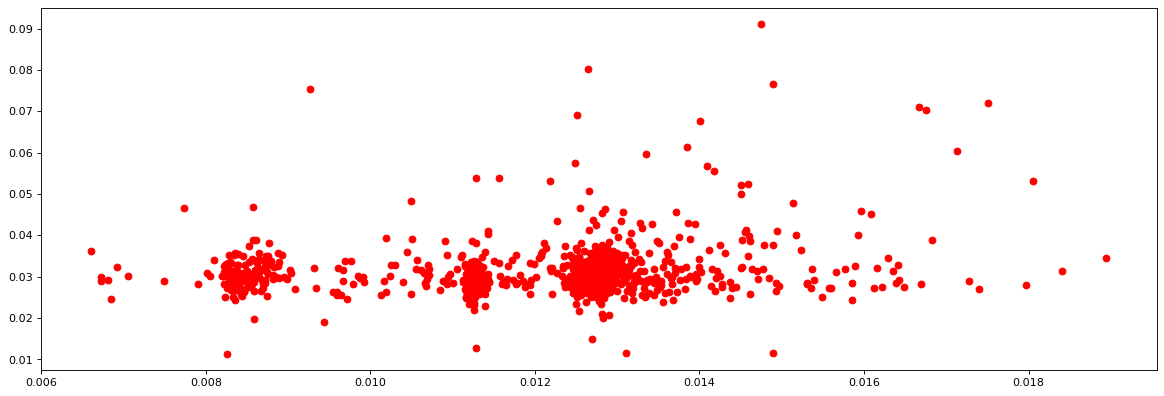

In [538]:
plot_scatter(processed_sensor_29, df_buxco.frequency)
plot_scatter(processed_sensor_30, df_buxco.frequency)
plot_scatter(processed_sensor_105, df_buxco.frequency)

In [541]:
def set_max_1(data):
    return (1/max(data)) * np.array(data)

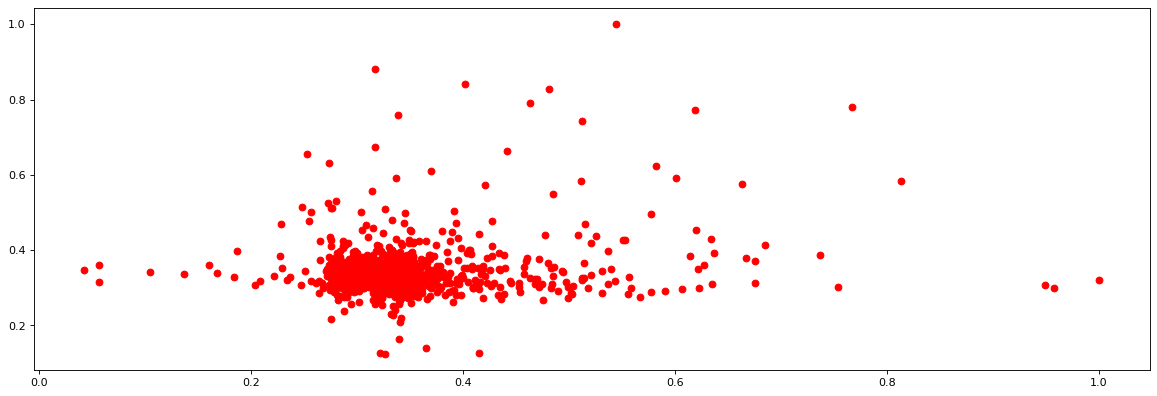

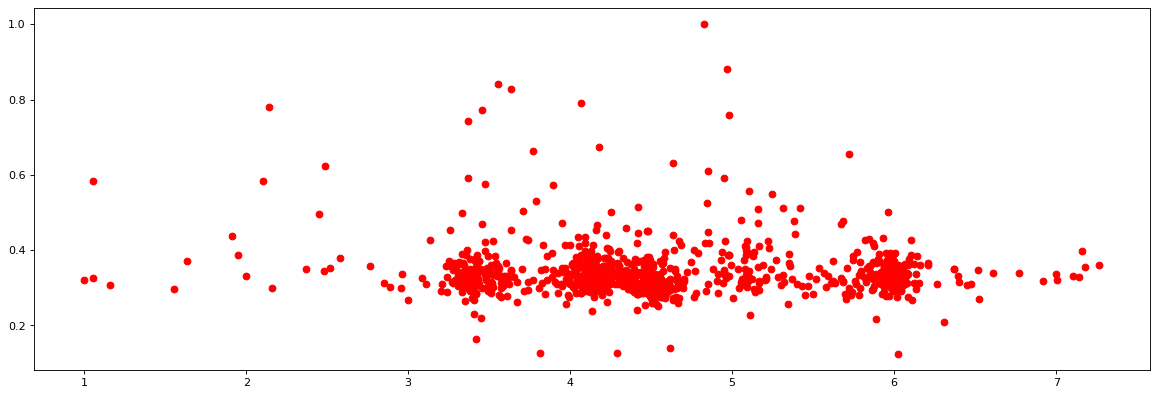

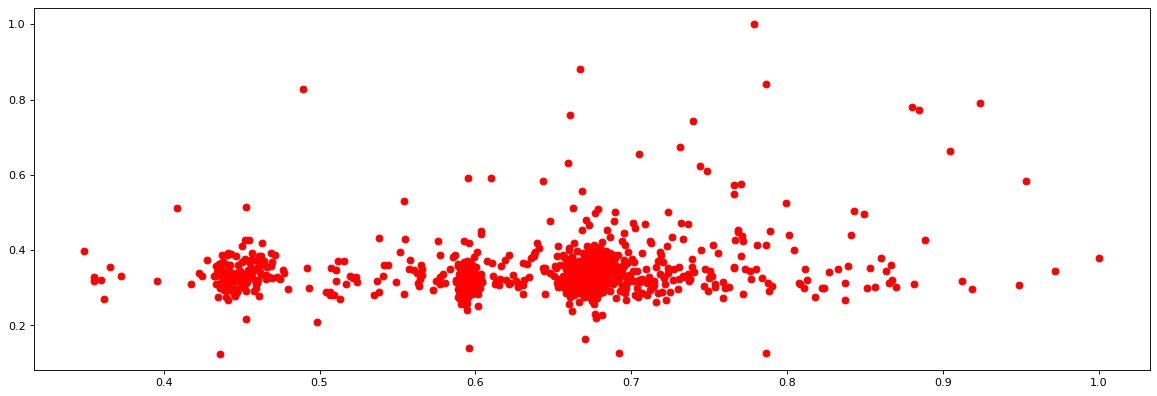

In [547]:
processed_sensor_29 = set_max_1(processed_sensor_29)
processed_sensor_30 = set_max_1(processed_sensor_30)
processed_sensor_105 = set_max_1(processed_sensor_105)
df_buxco.frequency = set_max_1(df_buxco.frequency)

plot_scatter(processed_sensor_29, df_buxco.frequency)
plot_scatter(processed_sensor_30, df_buxco.frequency)
plot_scatter(processed_sensor_105, df_buxco.frequency)

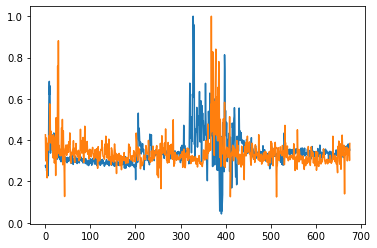

In [548]:
plt.plot(df_buxco.time, processed_sensor_29, label='x')
plt.plot(df_buxco.time, df_buxco.frequency, label='s')

In [552]:
def get_pct_change(data):
    return pandas.Series(data).pct_change()

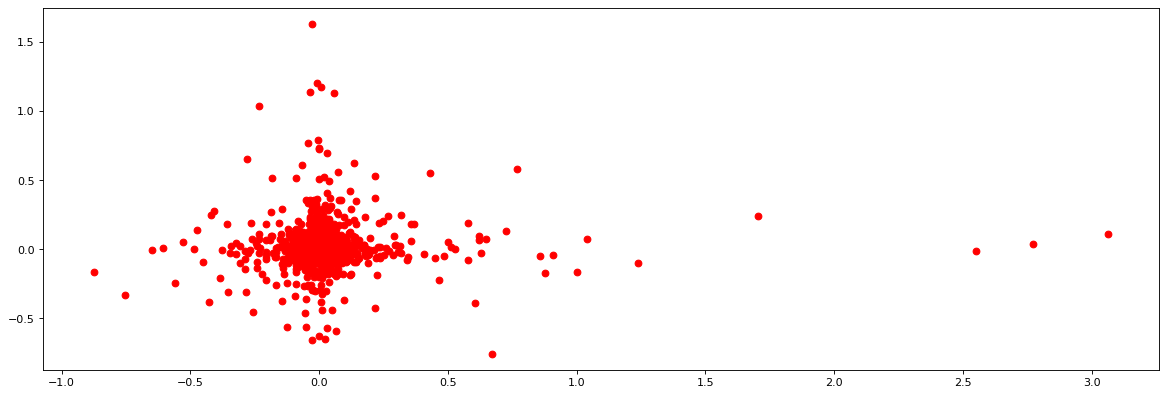

In [553]:
plot_scatter(get_pct_change(processed_sensor_29), get_pct_change(df_buxco.frequency))

In [561]:
def get_covar(a,b):
    return pandas.DataFrame(zip(a, b)).cov()


In [562]:
get_covar(processed_sensor_29, df_buxco.frequency)

,0,1
0,0.007097,0.001085
1,0.001085,0.005252


In [563]:
import statistics

0.34603880561008976

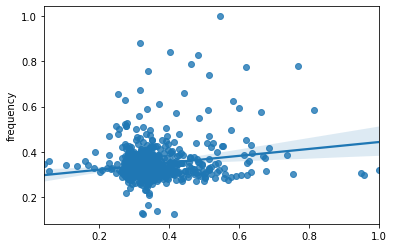

In [569]:
import seaborn as sns

sns.regplot(processed_sensor_29,df_buxco.frequency)

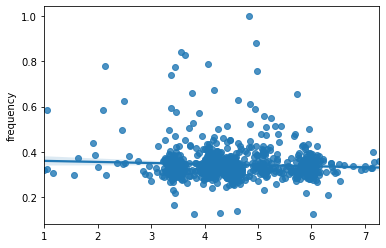

In [570]:
sns.regplot(processed_sensor_30,df_buxco.frequency)

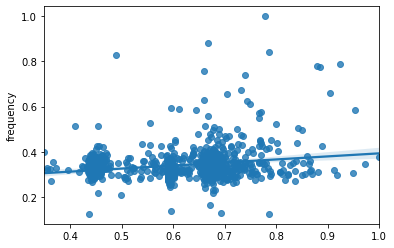

In [571]:
sns.regplot(processed_sensor_105,df_buxco.frequency)

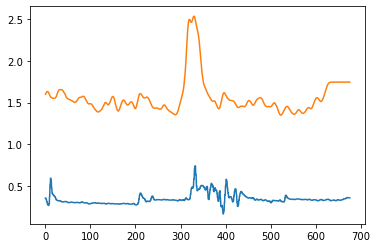

In [598]:
#tentando diminuir o ruido para ver se existe alguma semelhança...

testtta = df_buxco.frequency
testttb = processed_sensor_29
for i in range(0,5):
    temp = []
    for index in range(1, len(testtta), 2): 
        temp.append((testtta[index - 1] + testtta[index]) / 2)
        temp.append((testtta[index - 1] + testtta[index]) / 2)
    testtta = testtt
    temp = []
    for index in range(0, len(testttb), 2):
        temp.append((testttb[index - 1] + testttb[index]) / 2)
        temp.append((testttb[index - 1] + testttb[index]) / 2)
    testttb = temp

plt.plot(df_buxco.time, np.array(testttb)*1, label='x')
plt.plot(df_buxco.time, np.array(testtta)*1, label='s')

Text(0.5, 1.0, 'Normalizado')

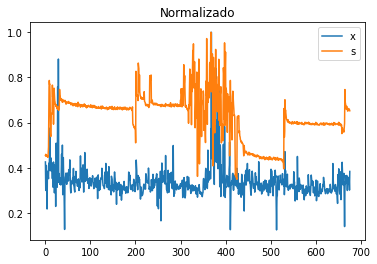

In [601]:
plt.plot(df_buxco.time, df_buxco.frequency, label='x')
plt.plot(df_buxco.time, processed_sensor_105, label='s')
plt.legend()
plt.title("Normalizado")

In [603]:
pandas.DataFrame(zip(processed_sensor_29,df_buxco.frequency), columns = ['magnitude','frequencia']).cov()

,magnitude,frequencia
magnitude,0.007097,0.001085
frequencia,0.001085,0.005252
